In [4]:
import pandas as pd

#Load in datasets
data1 = pd.read_excel('data.xlsx', sheet_name='CFD U.S. Norming Data', header=7)
data2 = pd.read_excel('data.xlsx', sheet_name='CFD-MR U.S. Norming Data', header=7)
data3 = pd.read_excel('data.xlsx', sheet_name='CFD-I U.S. Norming Data', header=7)

#Select relevant columns
columns = [2, 23] + [i for i in range(57, 117)]
face_data1 = data1.iloc[1:, columns].copy()
face_data2 = data2.iloc[1:, columns].copy()
face_data3 = data3.iloc[1:, columns].copy()

#Combine datasets
faces = pd.concat([face_data1, face_data2, face_data3], ignore_index=True)
faces.dropna(axis=1, how='any', inplace=True)
faces['Attractive'] = pd.to_numeric(faces['Attractive'])


/Users/maxforsey/Code/cs270/myenv/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


In [18]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np

# Create binned targets function
def bin_scores(scores):
    return np.round(scores).astype(int)

# Prepare features and target
X = faces.drop(['Attractive'], axis=1) 
y = bin_scores(faces['Attractive'])

faces['GenderSelf'] = faces['GenderSelf'].str.strip()
faces_female = faces[faces['GenderSelf'] == 'F']
faces_male = faces[faces['GenderSelf'] == 'M']

# Prepare female features and target
X_female = faces_female.drop(['Attractive'], axis=1)
y_female = bin_scores(faces_female['Attractive'])

# Prepare male features and target
X_male = faces_male.drop(['Attractive'], axis=1)
y_male = bin_scores(faces_male['Attractive'])

# Create preprocessing pipeline
categorical_features = ['GenderSelf']
numeric_features = [col for col in X.columns if col not in categorical_features]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

# Full dataset model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

svm_full = SVC(kernel='rbf', random_state=42)
svm_full.fit(X_train_processed, y_train)
full_accuracy = svm_full.score(X_test_processed, y_test)
print(f"Full dataset accuracy: {full_accuracy:.3f}")

# Female dataset model
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_female, y_female, test_size=0.2, random_state=42)
X_train_f_processed = preprocessor.fit_transform(X_train_f)
X_test_f_processed = preprocessor.transform(X_test_f)

svm_female = SVC(kernel='rbf', random_state=42)
svm_female.fit(X_train_f_processed, y_train_f)
female_accuracy = svm_female.score(X_test_f_processed, y_test_f)
print(f"Female dataset accuracy: {female_accuracy:.3f}")

# Male dataset model
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_male, y_male, test_size=0.2, random_state=42)
X_train_m_processed = preprocessor.fit_transform(X_train_m)
X_test_m_processed = preprocessor.transform(X_test_m)

svm_male = SVC(kernel='rbf', random_state=42)
svm_male.fit(X_train_m_processed, y_train_m)
male_accuracy = svm_male.score(X_test_m_processed, y_test_m)
print(f"Male dataset accuracy: {male_accuracy:.3f}")

Full dataset accuracy: 0.536
Female dataset accuracy: 0.412
Male dataset accuracy: 0.476


In [20]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import json
from sklearn.base import BaseEstimator

# Define parameter grid for SVC
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1, 1],
    'kernel': ['rbf', 'poly']
}

# Create base pipeline for grid search
base_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('svc', SVC(probability=True))
])

# Perform grid search
grid_search = GridSearchCV(
    base_pipeline,
    {'svc__' + key: value for key, value in param_grid.items()},
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

# Get top 50 models from grid search results
results = []
for params, mean_score in zip(grid_search.cv_results_['params'], 
                            grid_search.cv_results_['mean_test_score']):
    results.append((params, mean_score))

top_50_configs = sorted(results, key=lambda x: x[1], reverse=True)[:50]

# Function to convert pipeline to JSON
def pipeline_to_json(pipeline_params):
    return json.dumps({
        'preprocessor': 'standard_categorical',  # Identifier for our preprocessor
        'svc_params': {
            k.replace('svc__', ''): v for k, v in pipeline_params.items()
        }
    })

# Function to create pipeline from JSON
def create_pipeline_from_json(json_str):
    config = json.loads(json_str)
    svc_params = config['svc_params']
    svc_params['probability'] = True
    
    return Pipeline([
        ('preprocessor', preprocessor),
        ('svc', SVC(**svc_params))
    ])

# Create ensemble from top 50 models
full_models = []
for i, (params, score) in enumerate(top_50_configs):
    # Convert to JSON and back to simulate serialization
    json_config = pipeline_to_json(params)
    pipeline = create_pipeline_from_json(json_config)
    full_models.append((f'model_{i}', pipeline))

# Create final ensemble
final_ensemble = VotingClassifier(
    estimators=full_models,
    voting='soft'
)

# Fit the final ensemble
final_ensemble.fit(X_train, y_train)

# Make predictions
ensemble_predictions = final_ensemble.predict(X_test)
ensemble_accuracy = (ensemble_predictions == y_test).mean()
print(f"Ensemble accuracy: {ensemble_accuracy:.3f}")

best_score = top_50_configs[0][1]  # Score of the best model
avg_score = np.mean([score for _, score in top_50_configs])

print(f"Best model accuracy: {best_score:.3f}")
print(f"Average accuracy of top 50 models: {avg_score:.3f}")

example_config = pipeline_to_json(top_50_configs[0][0])
print("\nExample pipeline configuration:")
print(example_config)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/maxforsey/Code/cs270/myenv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Ensemble accuracy: 0.482
Best model accuracy: 0.499
Average accuracy of top 50 models: 0.438

Example pipeline configuration:
{"preprocessor": "standard_categorical", "svc_params": {"C": 1, "gamma": "scale", "kernel": "rbf"}}


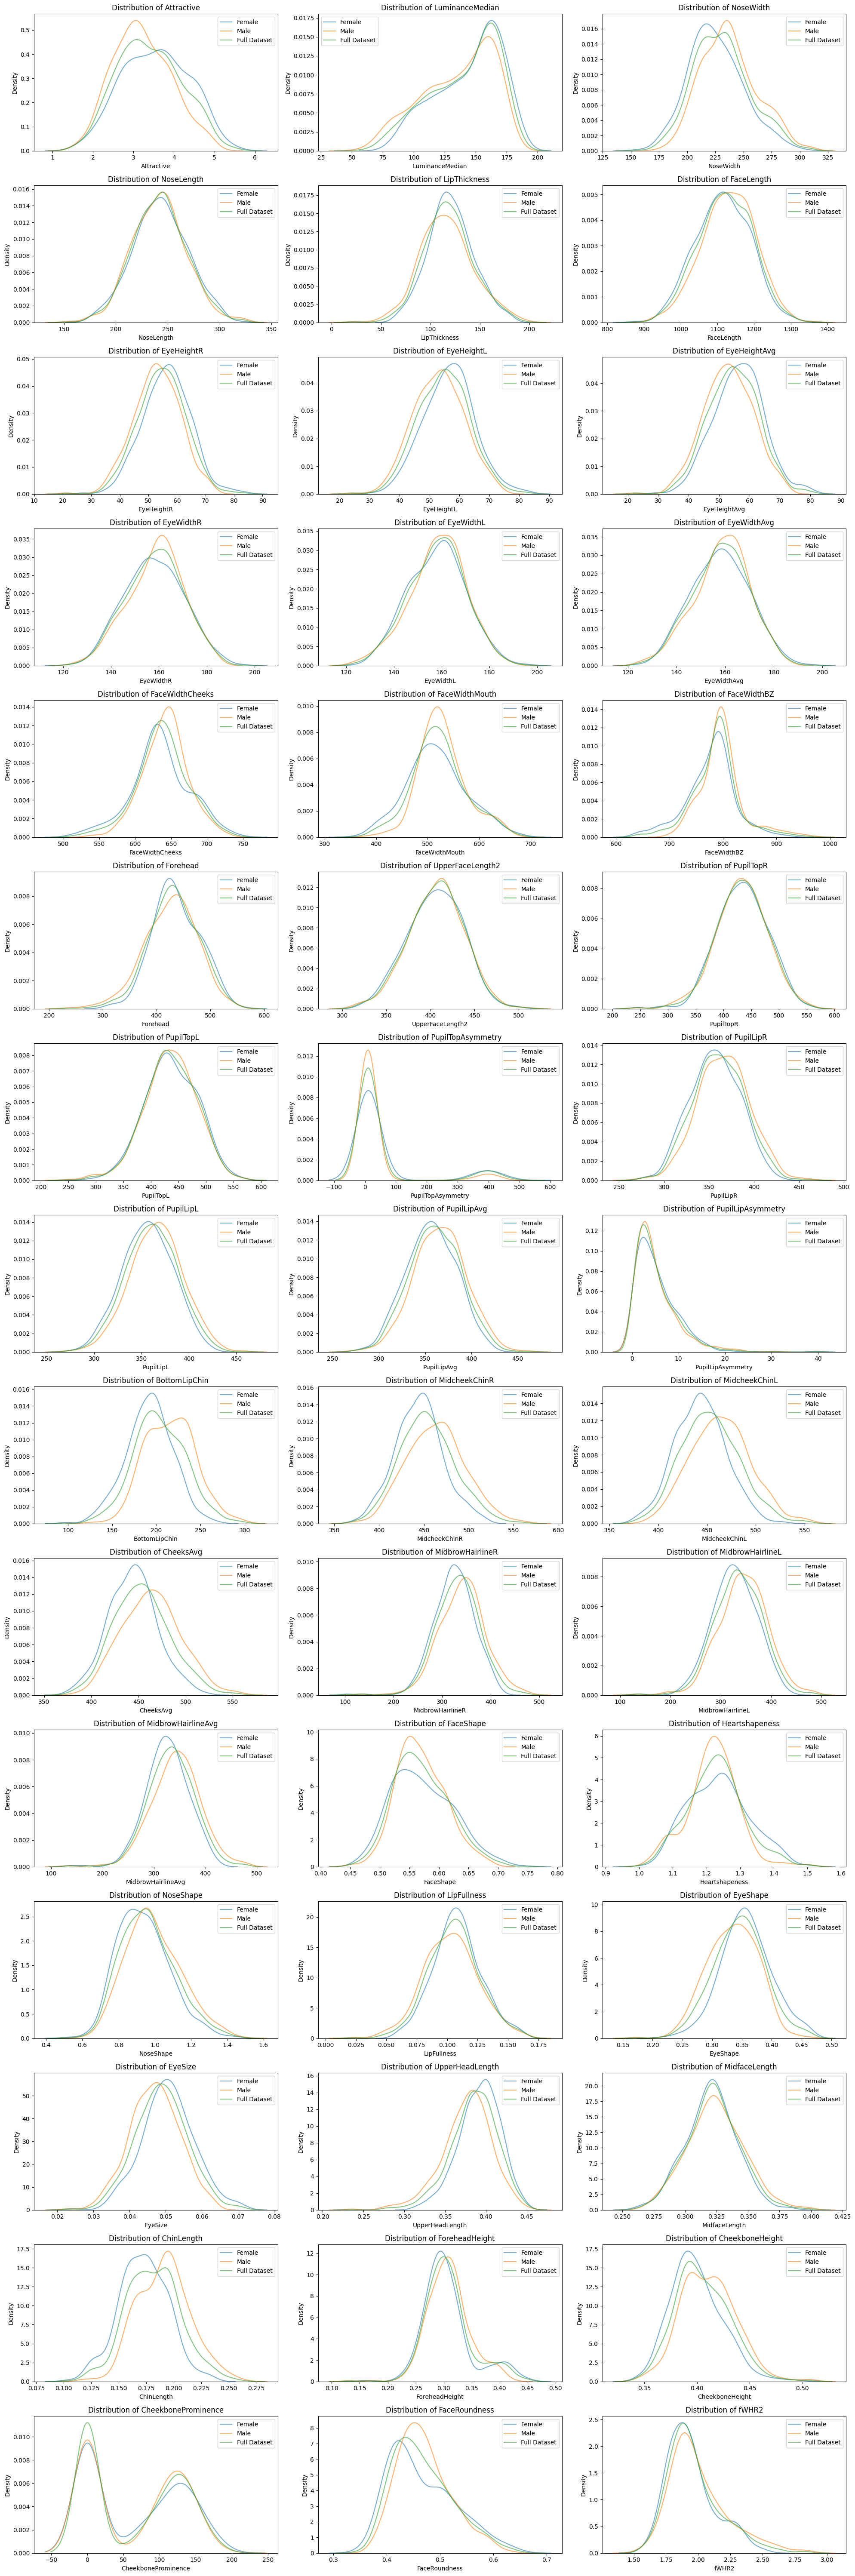

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get numeric columns (excluding GenderSelf)
numeric_cols = [col for col in faces.columns if col != 'GenderSelf']

# Calculate number of rows and columns for subplots
n_features = len(numeric_cols)
n_cols = 3  # Number of columns in the grid
n_rows = (n_features + n_cols - 1) // n_cols  # Ceiling division

# Create figure with subplots
plt.figure(figsize=(20, n_rows * 4))

# Plot each feature
for idx, feature in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, idx)
    
    # Plot density for each dataset
    sns.kdeplot(data=faces_female, x=feature, label='Female', alpha=0.6)
    sns.kdeplot(data=faces_male, x=feature, label='Male', alpha=0.6)
    sns.kdeplot(data=faces, x=feature, label='Full Dataset', alpha=0.6)
    
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()